In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
df = pd.read_csv('stock_features.csv', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
target ='close'
features = df.drop(columns=['date', target]).values
X = features.copy()
y = df[target].copy().values.reshape(-1, 1)

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X)
y_train_scaled = scaler_y.fit_transform(y)


def create_sequneces(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)


In [17]:
"""数据增强"""
def moving_average_smoothing(series, window_size=3):
    smoothed_data = np.empty_like(series)  # 创建一个与原始数据形状相同的空数组
    for col in range(series.shape[1]):
        # 对每一列(每个特征)进行平滑处理
        smoothed_data[:,col] = np.convolve(series[:,col], np.ones(window_size)/window_size, mode='same')
    return smoothed_data

def random_noise(data, noise_factor=0.01):
    """随机噪声"""
    noise = noise_factor + np.random.randn(*data.shape)
    return data + noise

def time_series_shift(series, shift_range=5):
    """时间序列平移"""
    shift = np.random.randint(-shift_range, shift_range + 1)
    return np.roll(series, shift, axis=0)

def data_augmentation(X, y, num_augmentations=5):
    augmented_X, augmented_y = [], []
    for i in range(len(X)):
        # 移动平均平滑
        augmented_X.append(X[i])
        augmented_y.append(y[i])
        for _ in range(num_augmentations):
            # 增强方法1 平滑处理
            X_smooth = moving_average_smoothing(X[i])
            # 增加方法2 添加噪声
            X_noise = random_noise(X_smooth)
            # 增加方法3 时间偏移
            X_shift = time_series_shift(X_noise)
            augmented_X.append(X_shift)
            augmented_y.append(y[i])
    return np.array(augmented_X), np.array(augmented_y)

In [ ]:
def plot_history(history, fold =1):
    plt.figure(figsize=(16, 6))
    plt.plot(history.history['loss'], label=f'Fold {fold + 1} - Training Loss', color='blue', linewidth=2)
    # 绘制验证损失曲线（如果有验证集）
    plt.plot(history.history['val_loss'], label=f'Fold {fold + 1} - Validation Loss', color='orange', linewidth=2)

    plt.title(f'Fold {fold + 1} -Model Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
window_sizes = [10, 30, 60, 90, 120]
metrics = ['MSE', 'RMSE', 'MAE', 'R2']

results = {window_size: {metric: [] for metric in metrics} for window_size in window_sizes}

def train_windows(X, y, window_size=24, stride=1):
    """
    将时间序列数据划分为多个窗口，每个窗口包含过去window_size个时间步的数据和下一个时间步的标签。
    """
    X_train, y_train = create_sequneces(X_train_scaled, y_train_scaled, window_size)
    print("划分数据集...")
    # X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, shuffle=False)


    X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train, y_train)

    # X_val,X_test, y_val,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

    print(f"Origin traning data shape: {X_train.shape}")
    print(f"Augmented traning data shape: {X_train_full_augmented.shape}")

    print("交叉验证...")
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)
    result = {}
    for fold,(train_index, val_index) in enumerate(tscv.split(X_train_full_augmented)):
        print(f"Fold {fold + 1}:")
        X_train_fold, X_val_fold = X_train_full_augmented[train_index], X_train_full_augmented[val_index]
        y_train_fold, y_val_fold = y_train_full_augmented[train_index], y_train_full_augmented[val_index]

        print("构建LSTM模型...")
        model = Sequential([
            LSTM(units=64, 
                input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True,
                kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.2),
            LSTM(units=64, return_sequences=False),
            Dropout(0.2),
            Dense(units=1)])

        model.compile(optimizer=Adam(learning_rate= 0.0001), loss='mean_squared_error', metrics=['mae'])
        
        model.summary()
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1, callbacks=[early_stopping])
        plot_history(history=history, fold=fold)

        val_predictions = model.predict(X_val_fold)
        val_predictions_prices = scaler_y.inverse_transform(val_predictions)
        val_real_prices = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1))

        mse = mean_squared_error(val_real_prices, val_predictions_prices)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_real_prices, val_predictions_prices)
        r2 = r2_score(val_real_prices, val_predictions)
        result['MSE'].append(mse)
        result['RMSE'].append(rmse)
        result['MAE'].append(mae)
        result['R2'].append(r2)
    return result

for window_size in window_sizes:
    print(f"Window Size: {window_size}")
    result = train_windows(X, y, window_size=window_size)
    results[window_size] = result

averages = {window_size: {metric: np.mean(result[metric]) for metric in result} for window_size, result in results.items()}

# 对指标进行对数变换，仅对MSE、RMSE进行操作
log_transformed_averages = {window_size: {
    "MSE": np.log(averages[window_size]["MSE"]),
    "RMSE": np.log(averages[window_size]["RMSE"]),
    "MAE": averages[window_size]["MAE"],
    "R2": averages[window_size]["R2"] 
    } for window_size in results.items()}

colors = sns.color_palette("Blues", len(window_sizes))
r = np.arange(len(metrics))
plt.figure(figsize=(10, 6))
barWidth = 0.15 # 每个柱子的宽度
for i, (window_size, result) in enumerate(results.items()):
    avg_metrics =[log_transformed_averages[metric] for metric in metrics]
    bars = plt.bar(r + i * barWidth, avg_metrics, width=barWidth, colors=colors[i], edgecolor='white', label=f'Window Size {window_size}')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel("Metrics", fontweight='bold')
plt.ylabel("log-transformed / Original Value", fontweight='bold')
plt.xticks([r + barWidth * (len(window_sizes) /2 -0.5) for r in np.arange(len(metrics))], metrics)

plt.title("Log-Transformed Evaluation Metrics for Different Window Sizes", fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()




划分数据集...
Origin traning data shape: (90273, 24, 36)
Augmented traning data shape: (541638, 24, 36)
交叉验证...
Fold 1:
构建LSTM模型...


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,945 (230.25 KB)

 Trainable params: 58,945 (230.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 299s 17ms/step - loss: 0.0805 - mae: 0.0504 - val_loss: 0.0039 - val_mae: 0.0517
Epoch 2/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 301s 18ms/step - loss: 0.0029 - mae: 0.0386 - val_loss: 0.0033 - val_mae: 0.0448
Epoch 3/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 309s 18ms/step - loss: 0.0027 - mae: 0.0376 - val_loss: 0.0024 - val_mae: 0.0382
Epoch 4/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 292s 17ms/step - loss: 0.0027 - mae: 0.0372 - val_loss: 0.0030 - val_mae: 0.0429
Epoch 5/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 256s 15ms/step - loss: 0.0027 - mae: 0.0373 - val_loss: 0.0030 - val_mae: 0.0447
Epoch 6/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 273s 16ms/step - loss: 0.0026 - mae: 0.0371 - val_loss: 0.0031 - val_mae: 0.0431
Epoch 7/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 267s 16ms/step - loss: 0.0026 - mae: 0.0368 - val_loss: 0.0034 - val_mae: 0.0447
Epoch 8/20
16922/16922 ━━━━━━━━━━━━━━━━━━━━ 257s 15ms/step - loss: 0.0026 - mae: 0.0368 - val_loss: 0.0018 - val_mae: 0.0331


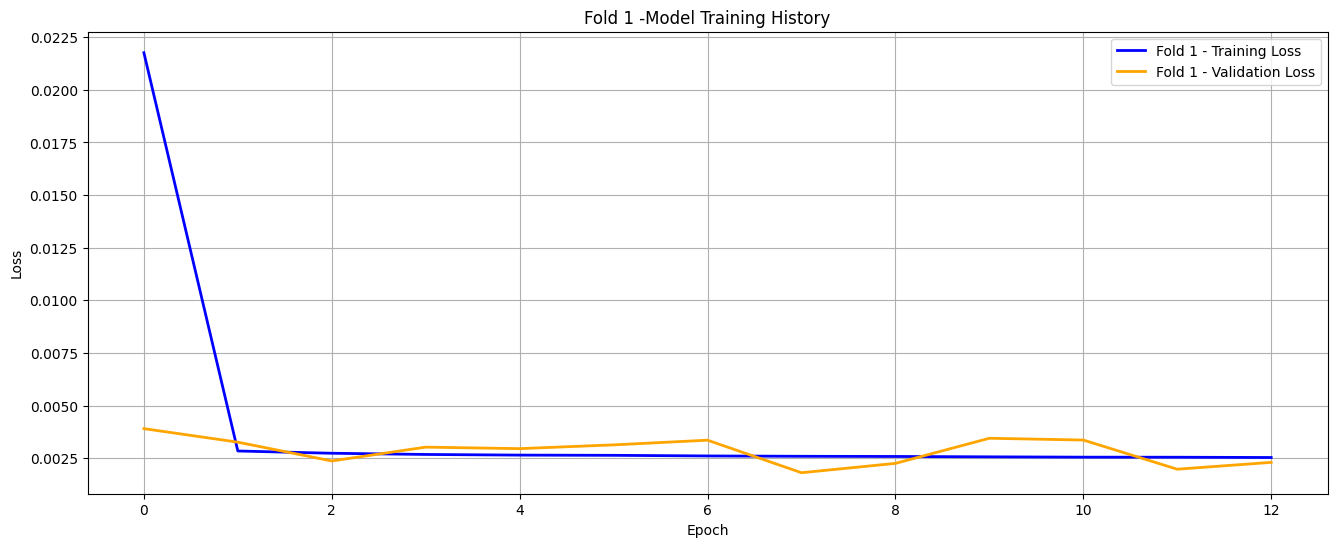

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
Fold 2:
构建LSTM模型...


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,945 (230.25 KB)

 Trainable params: 58,945 (230.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 281s 16ms/step - loss: 0.0864 - mae: 0.0528 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 2/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 259s 15ms/step - loss: 0.0029 - mae: 0.0383 - val_loss: 0.0024 - val_mae: 0.0388
Epoch 3/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 268s 16ms/step - loss: 0.0027 - mae: 0.0376 - val_loss: 0.0027 - val_mae: 0.0417
Epoch 4/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 262s 15ms/step - loss: 0.0027 - mae: 0.0372 - val_loss: 0.0031 - val_mae: 0.0475
Epoch 5/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 276s 16ms/step - loss: 0.0026 - mae: 0.0371 - val_loss: 0.0024 - val_mae: 0.0386
Epoch 6/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 333s 20ms/step - loss: 0.0026 - mae: 0.0371 - val_loss: 0.0024 - val_mae: 0.0394
Epoch 7/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 317s 19ms/step - loss: 0.0026 - mae: 0.0370 - val_loss: 0.0022 - val_mae: 0.0354
Epoch 8/20
16923/16923 ━━━━━━━━━━━━━━━━━━━━ 306s 18ms/step - loss: 0.0026 - mae: 0.0369 - val_loss: 0.0023 - val_mae: 0.0386


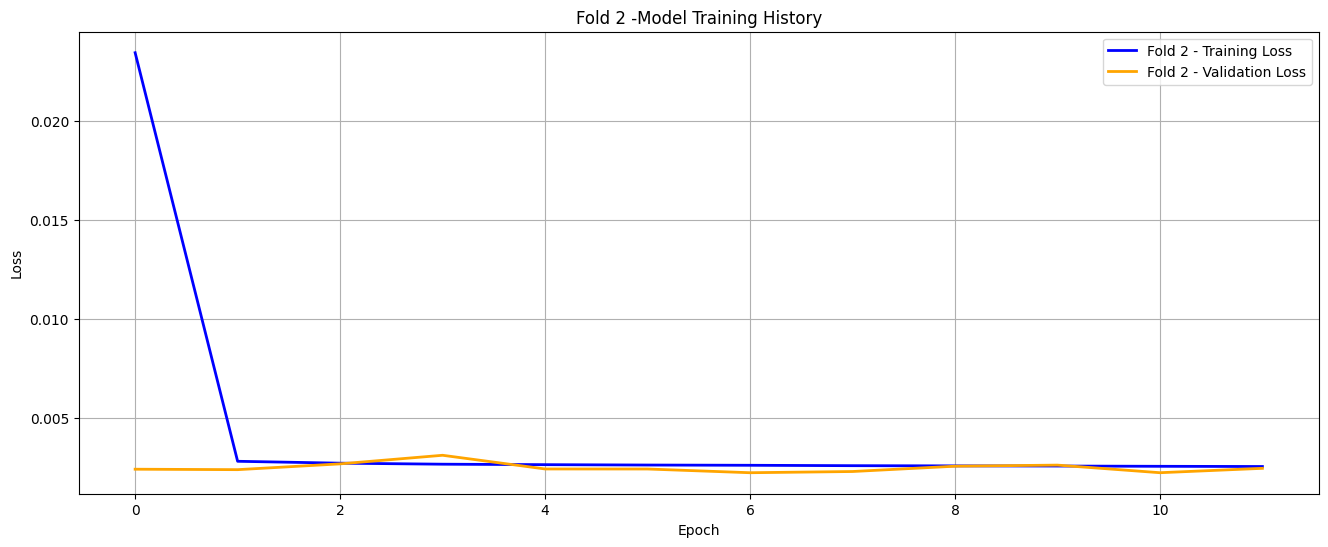

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Fold 3:
构建LSTM模型...


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,945 (230.25 KB)

 Trainable params: 58,945 (230.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16924/16924 ━━━━━━━━━━━━━━━━━━━━ 278s 16ms/step - loss: 0.0843 - mae: 0.0516 - val_loss: 0.0026 - val_mae: 0.0357
Epoch 2/20
16924/16924 ━━━━━━━━━━━━━━━━━━━━ 265s 16ms/step - loss: 0.0029 - mae: 0.0385 - val_loss: 0.0033 - val_mae: 0.0440
Epoch 3/20
16924/16924 ━━━━━━━━━━━━━━━━━━━━ 14432s 853ms/step - loss: 0.0028 - mae: 0.0377 - val_loss: 0.0023 - val_mae: 0.0333
Epoch 4/20
16924/16924 ━━━━━━━━━━━━━━━━━━━━ 11464s 677ms/step - loss: 0.0027 - mae: 0.0374 - val_loss: 0.0025 - val_mae: 0.0390
Epoch 5/20
 4184/16924 ━━━━━━━━━━━━━━━━━━━━ 2:32 12ms/step - loss: 0.0027 - mae: 0.0372

In [ ]:
X_train, y_train = create_sequneces(X_train_scaled, y_train_scaled)
print("划分数据集...")
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, shuffle=False)


X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train, y_train)

X_val,X_test, y_val,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

print(f"Origin traning data shape: {X_train.shape}")
print(f"Augmented traning data shape: {X_train_full_augmented.shape}")

print("交叉验证...")
tscv = TimeSeriesSplit(n_splits=5, test_size=30)
mse_scores =[]
rmse_scores = []
mae_scores =[]
r2_scores = []

for fold,(train_index, val_index) in enumerate(tscv.split(X_train_full_augmented)):
    print(f"Fold {fold + 1}:")
    X_train_fold, X_val_fold = X_train_full_augmented[train_index], X_train_full_augmented[val_index]
    y_train_fold, y_val_fold = y_train_full_augmented[train_index], y_train_full_augmented[val_index]

    print("构建LSTM模型...")
    model = Sequential([
        LSTM(units=64, 
             input_shape=(X_train.shape[1], X_train.shape[2]), 
             return_sequences=True,
             kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        LSTM(units=64, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)])

    model.compile(optimizer=Adam(learning_rate= 0.0001), loss='mean_squared_error', metrics=['mae'])
    
    model.summary()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1, callbacks=[early_stopping])
    plot_history(history=history, fold=fold)

    val_predictions = model.predict(X_val_fold)
    val_predictions_prices = scaler_y.inverse_transform(val_predictions)
    val_real_prices = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1))

    mse = mean_squared_error(val_real_prices, val_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(val_real_prices, val_predictions)
    r2 = r2_score(val_real_prices, val_predictions)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"MSE: {np.mean(mse_scores)}")    
print(f"RMSE: {np.mean(rmse_scores)}")
print(f"MAE: {np.mean(mae_scores)}")
print(f"R2: {np.mean(r2_scores)}")
